In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

In [2]:
"""
DOWNLOAD THE DATASET AT KAGGLE AT THIS LINK:
https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231
"""
file_path = "data/"
input_file = "oanda_db_USD_JPY_M1_20240501134919.csv"
# https://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/USDJPY
# input_file = "DAT_MT_USDJPY_M1_2020-02.csv"

# df = pd.read_csv(ibm)
df = pd.read_csv(f"{file_path}{input_file}")


In [3]:
df.head()

,ID,Date,Open,High,Low,Close,Volume,Complete,Created_at,Updated_at
0,41468,2024-03-15 00:00:00,148.112,148.134,148.098,148.101,235,1,2024-04-28 20:00:33,2024-04-28 20:00:33
1,41469,2024-03-15 00:01:00,148.101,148.104,148.078,148.080,273,1,2024-04-28 20:00:33,2024-04-28 20:00:33
2,41470,2024-03-15 00:02:00,148.080,148.090,148.052,148.052,222,1,2024-04-28 20:00:33,2024-04-28 20:00:33
3,41471,2024-03-15 00:03:00,148.052,148.088,148.052,148.087,208,1,2024-04-28 20:00:33,2024-04-28 20:00:33
4,41472,2024-03-15 00:04:00,148.087,148.111,148.081,148.096,201,1,2024-04-28 20:00:33,2024-04-28 20:00:33


In [4]:
window_size=21
def create_timestamps_ds(series, timestep_size=window_size):
    """
    時系列データをモデルが処理できる形式に変換する
    """
    time_stamps = []
    labels = []

    # collectionsモジュールのdeque（デック）というデータ構造を使用する
    # dequeは、両端で要素の追加や削除が高速に行えるリスト型のデータ構造です
    aux_deque = deque(maxlen=timestep_size)
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    #feed the timestamps list
    for i in range(len(series) - 1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    #feed the labels lsit
    for i in range(len(series) - 1):
        labels.append(series[i + 1])

    assert len(time_stamps) == len(labels), "Something went wrong"

    # torch-tensoring it 浮動小数点数のテンソルに変換
    # テンソルは、多次元配列のようなもので、PyTorchではニューラルネットワークの入力データやパラメータ、出力データを表現するために使用される
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()

    return features, labels

In [5]:
@variational_estimator
class NN(nn.Module):
    """
    ベイジアンLSTMを使用したニューラルネットワーク
    時系列データのパターンを学習し、未来の株価を予測するために使用される
    """
    def __init__(self):
        """
        ニューラルネットワークのレイヤーを定義する
        BayesianLSTMは、LSTM（Long Short-Term Memory）は、時系列データのパターンを学習するために使用される
        nn.Linearは、全結合レイヤー（線形レイヤー）であり、ニューラルネットワークの各レイヤーが前のレイヤーと全結合していることを意味する
        """
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        """
        ニューラルネットワークの順伝播を定義する
        つまり、入力データがどのようにネットワークを通過し、出力を生成するかを定義
        まずBayesianLSTMレイヤーを通過し、その出力が全結合レイヤーに渡され、最終的な出力が生成される
        """
        x_, _ = self.lstm_1(x)

        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [6]:
close_prices = df["Close"]
# 特徴量のスケーリングを行うためのツールで、特に機械学習モデルを訓練する前にデータを前処理する際に使用される
scaler = StandardScaler()

# 2次元配列に変換
close_prices_arr = np.array(close_prices).reshape(-1, 1)
# スケーリング
close_prices = scaler.fit_transform(close_prices_arr)


In [ ]:
# 時系列データをモデルが処理できる形式に変換する。
# データを一定の時間窓で区切ったもの（Xs）と、それぞれの時間窓の次の値（ys）を生成  
# Xsは各時間窓のデータを格納したリスト（または配列）で、ysはそれぞれの時間窓の次の値を格納したリスト
# これらは、時系列予測タスクにおける特徴量とラベルに相当します。
Xs, ys = create_timestamps_ds(close_prices)

In [8]:

# 訓練データとテストデータに分割
# Xsとysは、入力データと対応するラベル。訓練に使用される
# test_size=.25は、全体のデータセットのうち25%をテストデータとして使用することを指定する
# random_state=42は、データを分割する際のランダムシードを指定する
# shuffle=Falseは、データをシャッフルしないことを指定。時系列データの場合、データの順序が重要であるため、通常はシャッフルしない。
# 出力は、訓練データ（X_trainとy_train）とテストデータ（X_testとy_test）の4つのデータセットです。これらは、モデルの訓練と評価に使用される
X_train, X_test, y_train, y_test = train_test_split(
    Xs,
    ys,
    test_size=.25,
    random_state=42,
    shuffle=False)

# 訓練データ（X_trainとy_train）をデータセットに変換
ds = torch.utils.data.TensorDataset(X_train, y_train)
# 訓練データをバッチ処理するためのデータローダーを作成
# バッチサイズは一度にネットワークに供給されるデータの数（バッチサイズ）を指定
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)
print(f"Train size: {len(X_train)} Test size: {len(X_test)}")

net = NN()
# 損失関数を定義する。平均二乗誤差（MSE）を使用する
# 損失関数は、モデルの予測が実際のラベルからどれだけ離れているかを測定する
# 訓練中には、この損失を最小化するようにモデルのパラメータが調整される
criterion = nn.MSELoss()
# 最適化アルゴリズムを定義する。Adamアルゴリズムを使用する
# Adamは、確率的勾配降下法（SGD）の一種であり、モデルのパラメータを最適化するために使用される
# lr=0.001は、学習率を指定する。学習率は、モデルのパラメータを更新するステップの大きさを制御する
optimizer = optim.Adam(net.parameters(), lr=0.001)

/var/folders/w0/v7s_36jn3n934dw6x_x4_8yr0000gn/T/ipykernel_93332/2132416271.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  features = torch.tensor(time_stamps[timestep_size:]).float()


Train size: 31530 Test size: 10510


In [89]:
iteration = 0
# エポックのループです。エポックとは、訓練データ全体を一度通過することを指す
for epoch in range(10):
    # バッチのループ。バッチとは、訓練データを一部分ずつ処理するための小さなデータの塊
    for i, (datapoints, labels) in enumerate(dataloader_train):
        # 最適化アルゴリズムの勾配をゼロにリセット
        optimizer.zero_grad()
        
        # モデルの損失（エラー）を計算します。この損失は、モデルの予測と実際のラベルとの差を表す
        # sample_elboは、ベイジアンニューラルネットワークの損失を計算するための関数
        loss = net.sample_elbo(
            inputs=datapoints,
            labels=labels,
            criterion=criterion,
            sample_nbr=3,
            complexity_cost_weight=1 / X_train.shape[0])
        # 損失に対する各パラメータの勾配を計算する。パラメータを更新するために必要
        loss.backward()
        # 計算された勾配を使用して、モデルのパラメータを更新する
        optimizer.step()

        # 250回のイテレーションごとに、テストデータに対する損失を計算し、表示する
        iteration += 1
        if iteration % 250 == 0:
            preds_test = net(X_test)[:, 0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.3143
Iteration: 500 Val-loss: 0.2088
Iteration: 750 Val-loss: 0.1680
Iteration: 1000 Val-loss: 0.1668
Iteration: 1250 Val-loss: 0.1730
Iteration: 1500 Val-loss: 0.1375
Iteration: 1750 Val-loss: 0.1259
Iteration: 2000 Val-loss: 0.1185
Iteration: 2250 Val-loss: 0.1311
Iteration: 2500 Val-loss: 0.1084
Iteration: 2750 Val-loss: 0.1554
Iteration: 3000 Val-loss: 0.1095
Iteration: 3250 Val-loss: 0.0985
Iteration: 3500 Val-loss: 0.0852
Iteration: 3750 Val-loss: 0.0960
Iteration: 4000 Val-loss: 0.1320
Iteration: 4250 Val-loss: 0.1003
Iteration: 4500 Val-loss: 0.0898
Iteration: 4750 Val-loss: 0.0895
Iteration: 5000 Val-loss: 0.0961
Iteration: 5250 Val-loss: 0.1024
Iteration: 5500 Val-loss: 0.1001
Iteration: 5750 Val-loss: 0.1090
Iteration: 6000 Val-loss: 0.0746
Iteration: 6250 Val-loss: 0.0746
Iteration: 6500 Val-loss: 0.0836
Iteration: 6750 Val-loss: 0.1444
Iteration: 7000 Val-loss: 0.0827
Iteration: 7250 Val-loss: 0.0700
Iteration: 7500 Val-loss: 0.0756
Iteration: 77

In [90]:
# 時系列データを処理する際の「ウィンドウサイズ」を設定しています。
# ウィンドウサイズとは、一度にモデルが見る過去のデータポイントの数を指します。
# この場合、モデルは過去21ポイントのデータを見て、次のデータポイントを予測します。 
# この値は、時系列データをモデルが処理できる形式に変換する際に使用されます。
# create_timestamps_ds 関数内で、各ウィンドウ（または時間ステップ）に対応するデータポイントのセットを作成するために使用されます  
# ウィンドウサイズはハイパーパラメータであり、モデルの性能に影響を与えます。
window_size = 21
#pred_unscaled
original = df["Close"][1:][window_size:]  # データフレームdfから「Close」列を取得し、最初の要素とwindow_size以降の要素をスキップ
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])  # 「Date」列を日付型（datetime）に変換
df_pred = df_pred.reset_index()  # インデックスを0から始まる連番になるようにリセット

In [102]:
def pred_stock_future(
        X_test,
        future_length,
        sample_nbr=10):
    """
    与えられたテストデータ X_test を用いて、未来の株価を予測するためのものです。
    ベイジアンニューラルネットワークのモデルを使用して、指定された未来の日数 future_length にわたる株価の予測値を生成します。
    """
    global window_size
    global X_train
    global Xs
    global scaler

    # 予測値を格納するための空のリストを作成
    preds_test = []
    # 予測を開始する最初のデータポイントを取得
    # テストデータの最初のウィンドウを取得し、それをdeque（両端キュー）に変換します。
    # dequeは、両端で要素の追加や削除が高速に行えるリスト型のデータ構造です。
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0, :, 0].tolist(), maxlen=window_size)
    # 予測値のインデックスをdf["Date"] のような日付型を生成
    idx_pred = df["Date"][len(X_train) + window_size:].values
    # idx_pred = np.arange(len(X_train), len(Xs))

    # テストデータの各ウィンドウに対してループ
    for i in range(len(X_test)):
        # テストデータのウィンドウをモデルに供給し、未来の株価を予測
        # 現在のウィンドウをニューラルネットワークの入力として使用できる形式に変換します。
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        # 現在のウィンドウに対する予測値を生成します。sample_nbr 回繰り返され、それぞれの予測値がリスト pred に格納されます。
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        # 生成した予測値の平均をdequeに追加し、予測値のリスト全体を preds_test に追加します。
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)

        # 指定された未来の日数ごとに、dequeとテストデータのウィンドウを更新します。
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i + 1, :, :]
            test_deque = deque(test_begin[0, :, 0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)

    return idx_pred, preds_test

In [103]:
def get_confidence_intervals(preds_test, ci_multiplier):
    """
    予測結果の信頼区間を計算するためのものです。具体的には、予測値の平均と標準偏差を用いて、信頼区間の上限と下限を計算します。
    """
    global scaler
    # 予測値をPyTorchのテンソルに変換
    preds_test = torch.tensor(preds_test)
    # 予測値の平均を計算
    pred_mean = preds_test.mean(1)
    # 予測値の標準偏差を計算。テンソルからnumpy配列に変換。
    pred_std = preds_test.std(1).detach().cpu().numpy()
    # 予測値の標準偏差をPyTorchのテンソルに変換
    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    # 信頼区間の上限と下限を計算します。ci_multiplierは信頼区間の幅を制御するパラメータ
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    
    # 平均値、上限、下限を元のスケールに戻します。これは、モデルの入力データがスケーリング（正規化）されていた場合に必要です。
    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)

    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)

    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [104]:
# future_length=7
future_length = 3
# sample_nbr = 4
sample_nbr = 10
# ci_multiplier = 5
ci_multiplier = 2
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [105]:
print(idx_pred)

['2024-04-18T09:21:00.000000000' '2024-04-18T09:22:00.000000000'
 '2024-04-18T09:23:00.000000000' ... '2024-04-30T23:57:00.000000000'
 '2024-04-30T23:58:00.000000000' '2024-04-30T23:59:00.000000000']


In [94]:
# 実際の株価（df.Close）の最後の部分（予測結果と同じ長さ）を取得し、それを2次元配列に変換しています。
# y = np.array(df.close[-750:]).reshape(-1, 1)
y = np.array(df.Close[-len(upper_bound_unscaled):]).reshape(-1, 1)
# 予測結果の信頼区間の上限upper_bound_unscaled と下限 lower_bound_unscaled を比較し、それらが実際のデータ y の範囲内にあるかどうかを確認します。
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
# 上記の2つのブール値配列が等しいかどうかを判定しています。これは、実際の株価が信頼区間内に収まっている場合にTrueとなります。
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))

0.9056137012369172 our predictions are in our confidence interval


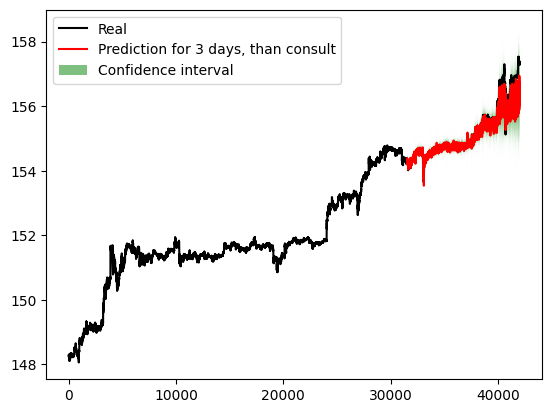

In [95]:
# プロットの色設定を定義します
params = {"ytick.color": "black",
          "xtick.color": "black",
          "axes.labelcolor": "black",
          "axes.edgecolor": "black"}
plt.rcParams.update(params)
# 実際の株価をプロットします。x軸は日付（df_pred.index）、y軸は株価（df_pred.Close）です。
# 線の色は黒で、ラベルは"Real"としています。
plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")
# 予測した株価をプロットします。x軸は予測値のインデックス（idx_pred）、y軸は予測値（pred_mean_unscaled）です。
# 線の色は赤で、ラベルは"Prediction for {} days, than consult"としています。
plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red")
# 予測結果の信頼区間をプロットします。
# x軸は予測値のインデックス（idx_pred）、
# y軸は信頼区間の上限（upper_bound_unscaled）と下限（lower_bound_unscaled）です。
# 領域の色は緑で、ラベルは"Confidence interval"としています。
# alpha=0.5により領域の色を半透明にしています。
plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:, 0],
                 y2=lower_bound_unscaled[:, 0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)
# プロットの凡例を表示します。 
plt.legend()

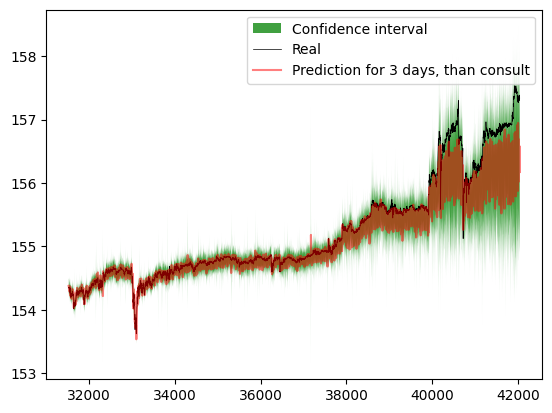

In [96]:
params = {"ytick.color": "black",
          "xtick.color": "black",
          "axes.labelcolor": "black",
          "axes.edgecolor": "black"}
plt.rcParams.update(params)

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:, 0],
                 y2=lower_bound_unscaled[:, 0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()

In [97]:
# Date、original, pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaledの値をCSVに出力する
# 保存先はdata/prediction.csvとする
# ヘッダーはDate、original、pred_mean_unscaled、upper_bound_unscaled、lower_bound_unscaledとする
# df_pred.columns = ["Date", "original", "pred_mean_unscaled", "upper_bound_unscaled", "lower_bound_unscaled"]
# df_pred["Date"] = df.Date
# df_pred["original"] = original
df_new = pd.DataFrame()
df_new.index = idx_pred
df_new["real"] = df_pred.Close[-len(pred_mean_unscaled):]
df_new["pred_mean_unscaled"] = pred_mean_unscaled
df_new["upper_bound_unscaled"] = upper_bound_unscaled[:, 0]
df_new["lower_bound_unscaled"] = lower_bound_unscaled[:, 0]

# 現時刻を取得して、YYYY_MM_DD-HH_mm_SSのフォーマットにする
import datetime
# CSVファイルに出力
df_new.to_csv(f"data/prediction_{input_file.split('.')[0]}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")


In [98]:
import os

for i in range(3):
    os.system('afplay /System/Library/Sounds/Glass.aiff')